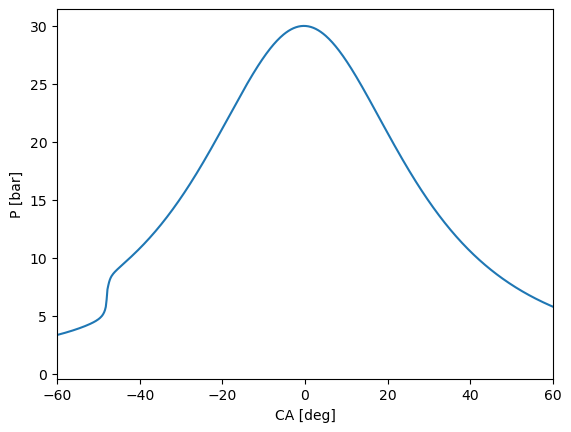

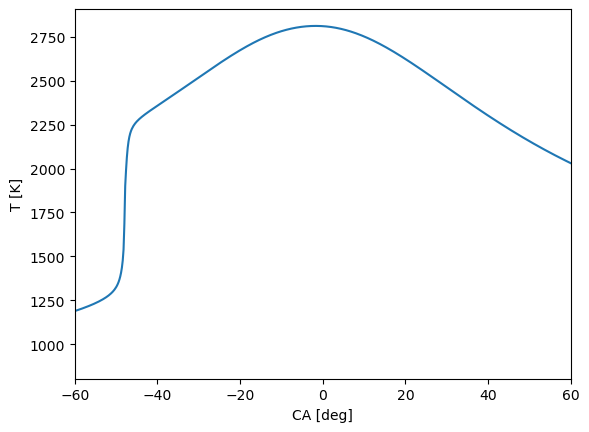

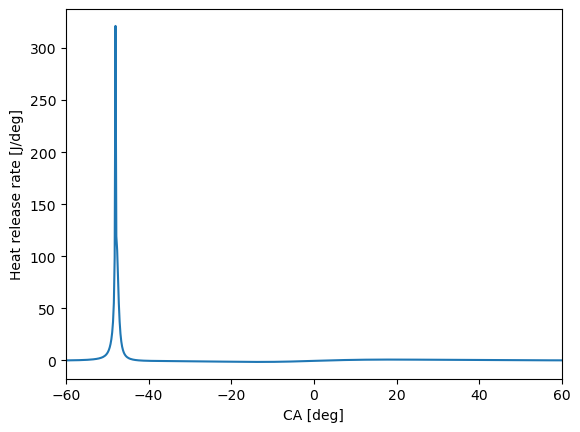

In [6]:
"""
Simulation of a internal combustion engine.
"""

import cantera as ct
import numpy as np
import csv

#------------------------------------------------------
# Input Parameters
rpm = 9000.0  # engine speed [rpm]
bore = 82.55  # bore diameter [mm]
stroke = 114.3 # stroke [mm]
cratio = 10.0  # compression ratio [-]
conrod = 200.0 # connecting rod [mm]

# initial temperature, pressure, and equivalence ratio
T_ini = 900.0 # [K]
p_ini = 1.0e5 # [Pa]
phi = 0.33

# outer temperature, pressure, and composition
T_out = 300.0 # [K]
p_out = 1.0e5 # [Pa]
c_out = 'O2:1.0, N2:3.76'

# Reaction mechanism name
reaction_mechanism = 'Jerzembeck.yaml'

# Simulation time
ca_start = -144.0 # start CA [deg]
ca_end = 180.0 # end CA [deg]
ca_step = 0.01 # step CA [deg]
ca_out = 0.2 # output CA [deg]

#------------------------------------------------------
# load reaction mechanism
gas = ct.Solution(reaction_mechanism)

# define initial state
gas.TP = T_ini, p_ini
gas.set_equivalence_ratio(phi, 'IXC8H18', 'O2:1.0, N2:3.76')
r = ct.IdealGasReactor(gas)
sim = ct.ReactorNet([r])
gas.TPX = T_out, p_out, c_out
outer = ct.Reservoir(gas)

# convert time to crank angle [rad]
rps = rpm / 60.0
def crank_angle(t):
    return 2.0 * np.pi * rps * t + ca_start * np.pi / 180.0

# set up IC engine parameters
stroke *= 0.001
bore *= 0.001
conrod *= 0.001
area = 0.25 * np.pi * bore * bore
vol_h = stroke * area  # volume cylinder
vol_c = vol_h / (cratio - 1.0) # volume combustion dome
ca = crank_angle(0.0) # initial CA
r_ca = stroke * 0.5 # crank radius
vol_ini= (r_ca + conrod - (r_ca * np.cos(ca) + np.sqrt(conrod**2 - r_ca**2 * np.sin(ca)**2))) * area + vol_c
r.volume = vol_ini # initial volume

# set up piston 
piston = ct.Wall(outer, r)
piston.area = area  # piston area
def piston_speed(t):
    ca = crank_angle(t)
    return -2.0 * np.pi * rps * (r_ca * np.sin(ca) + r_ca**2 * np.sin(2.0 * ca) / 2.0 / np.sqrt(conrod**2 - r_ca**2 * np.sin(ca)**2))
piston.velocity = piston_speed  # piston speed

# set up time
t_sim = (ca_end - ca_start) / rps / 360.0  # simulation time
t_step = ca_step / rps / 360.0  # simulation time step
t_out = ca_out / rps / 360.0 # simulation output time
ttt = 0.0

# set up output data arrays
states = ct.SolutionArray(r.thermo)
t = []
heat_release_rate = []

# do simulation
for t_i in np.arange(0, t_sim, t_step):
    sim.advance(t_i)

    # write output data
    if t_i >= ttt:
        ca = crank_angle(t_i) * 180.0 / np.pi
        t.append(ca)

        states.append(r.thermo.state)

        hr = -r.volume * ct.gas_constant * r.T * np.sum(gas.standard_enthalpies_RT * r.thermo.net_production_rates, 0)
        hr = hr * t_step / ca_step
        heat_release_rate.append(hr)

        ttt += t_out

#------------------------------------------------------
# Plot Results in matplotlib
import matplotlib.pyplot as plt

# pressure
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.plot(t, states.P / 1.0e5)
ax1.set_ylabel('P [bar]')
ax1.set_xlabel('CA [deg]')
ax1.set_xlim(-60, 60)

# temperature
fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.plot(t, states.T)
ax2.set_ylabel('T [K]')
ax2.set_xlabel('CA [deg]')
ax2.set_xlim(-60, 60)

# heat release rate
fig3 = plt.figure()
ax3 = fig3.add_subplot()
ax3.plot(t, heat_release_rate)
ax3.set_ylabel('Heat release rate [J/deg]')
ax3.set_xlabel('CA [deg]')
ax3.set_xlim(-60, 60)

plt.show()

https://cattech-lab.com/science-tools/cantera-ic-engine/